In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from copy import deepcopy

In [2]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing, conformalized_quantile

In [3]:
import random
random.seed(42)
np.random.seed(42)
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [4]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

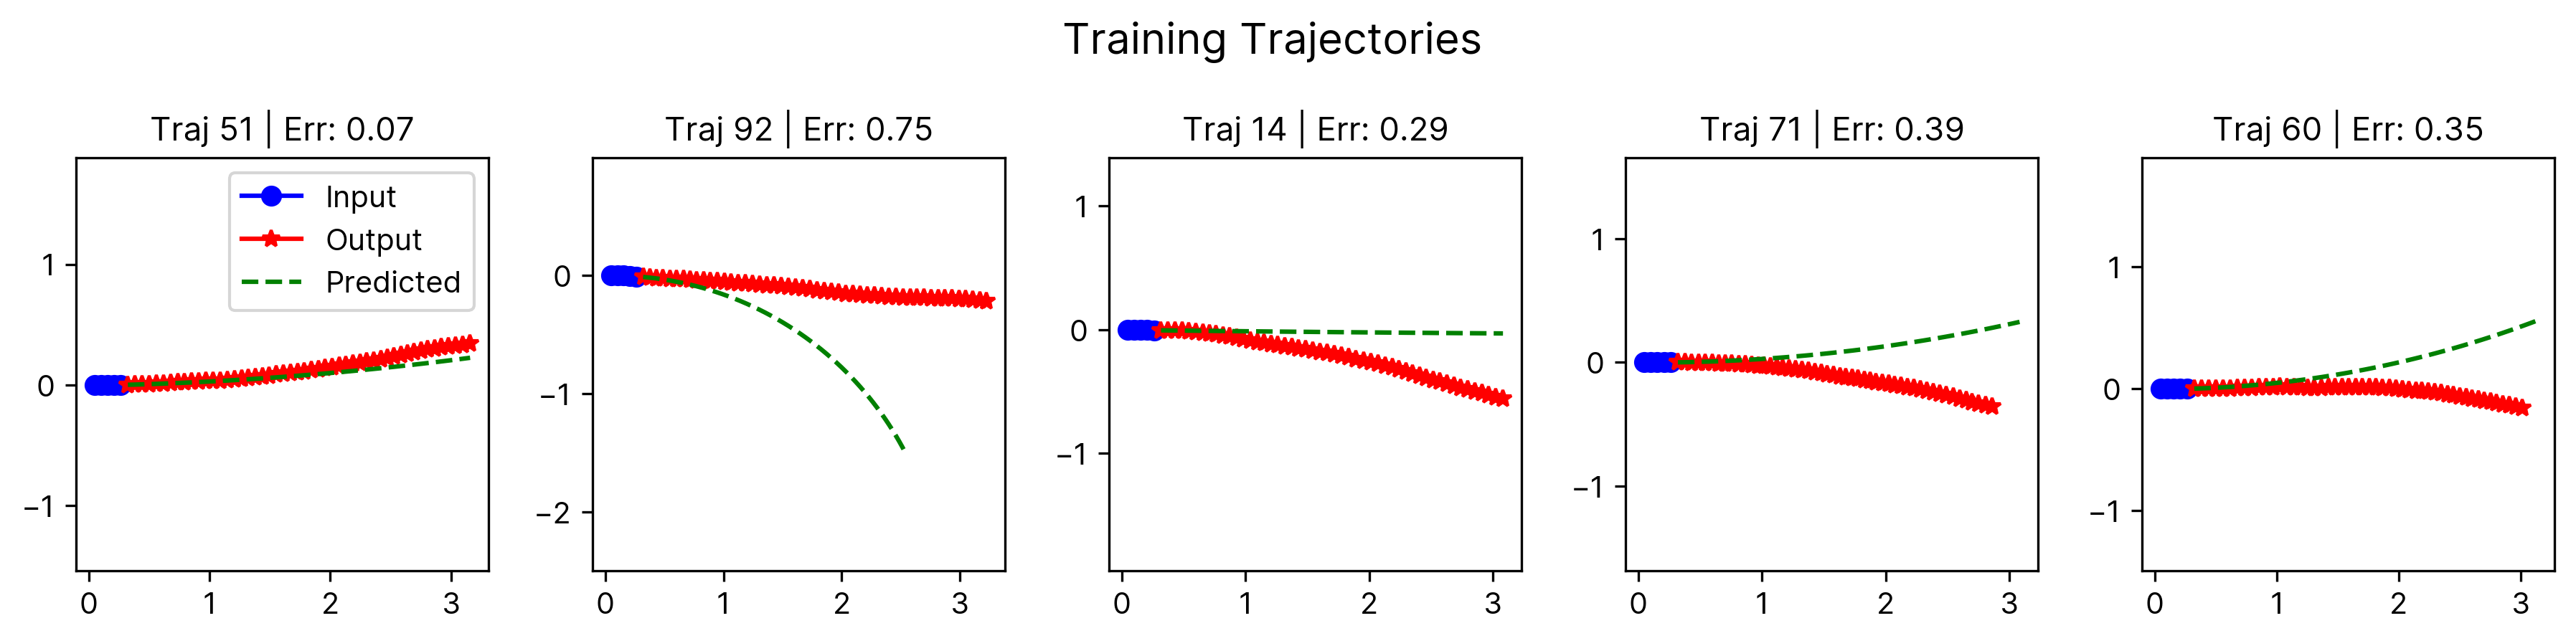

In [5]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

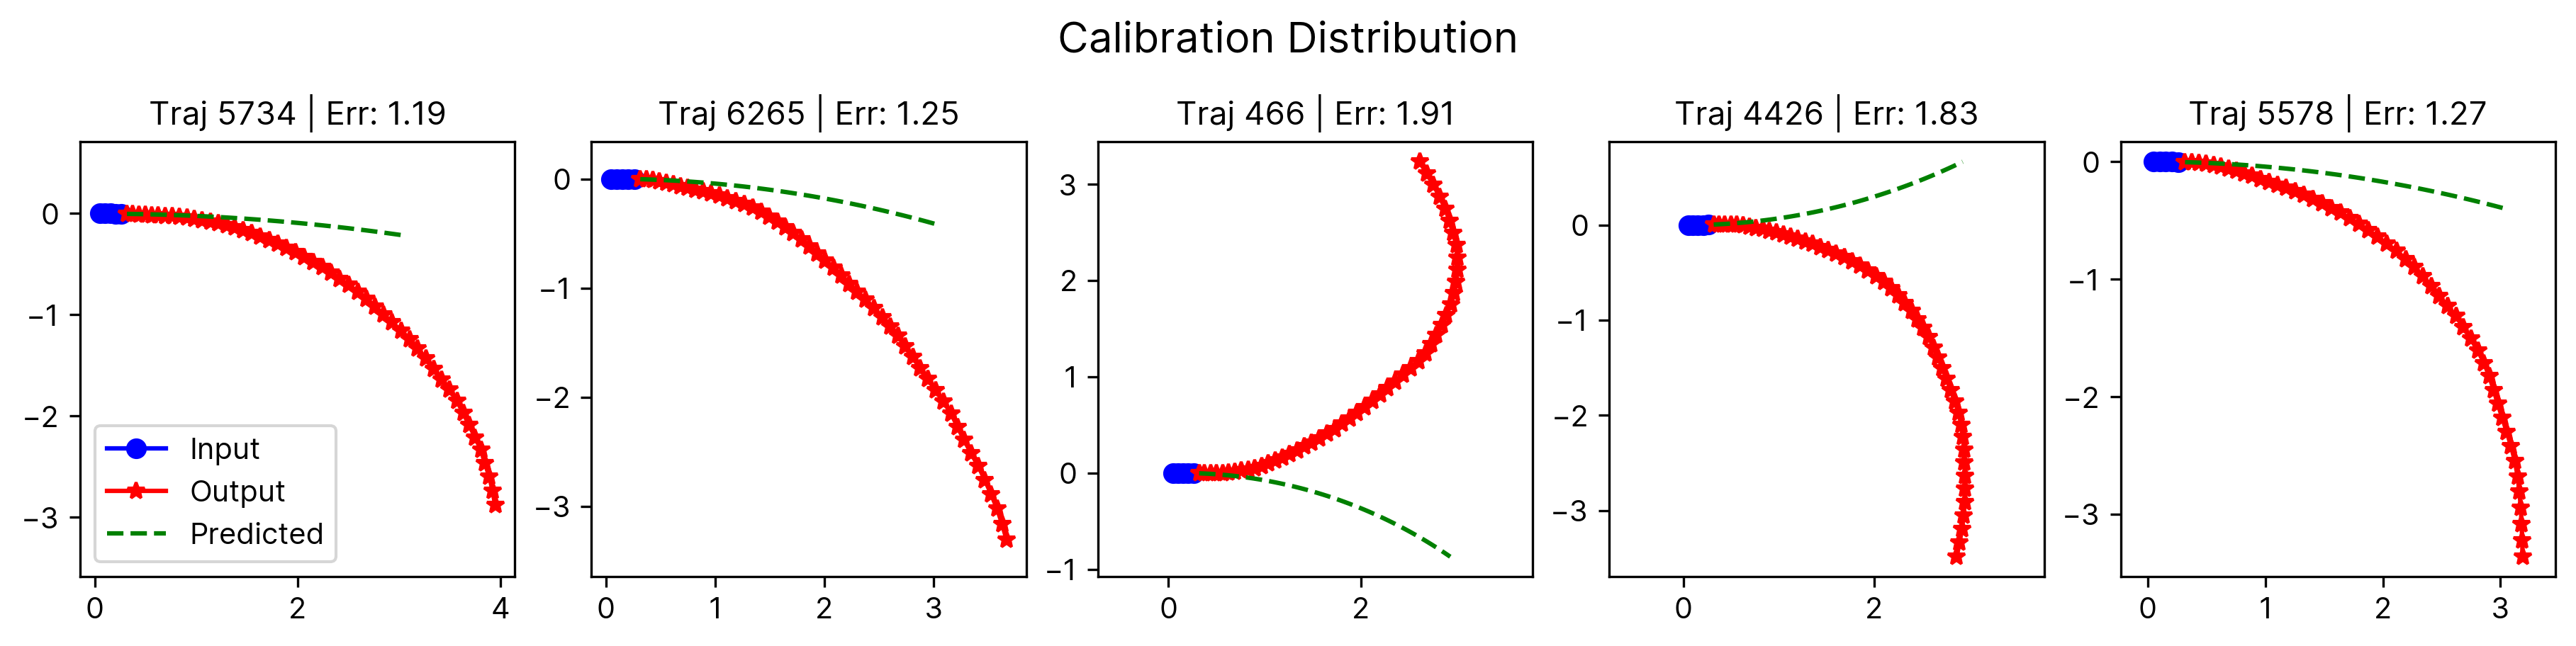

In [6]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [7]:
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,-1,:2] - env_Y_hat[:,-1,:2]
np.random.shuffle(Z_env)

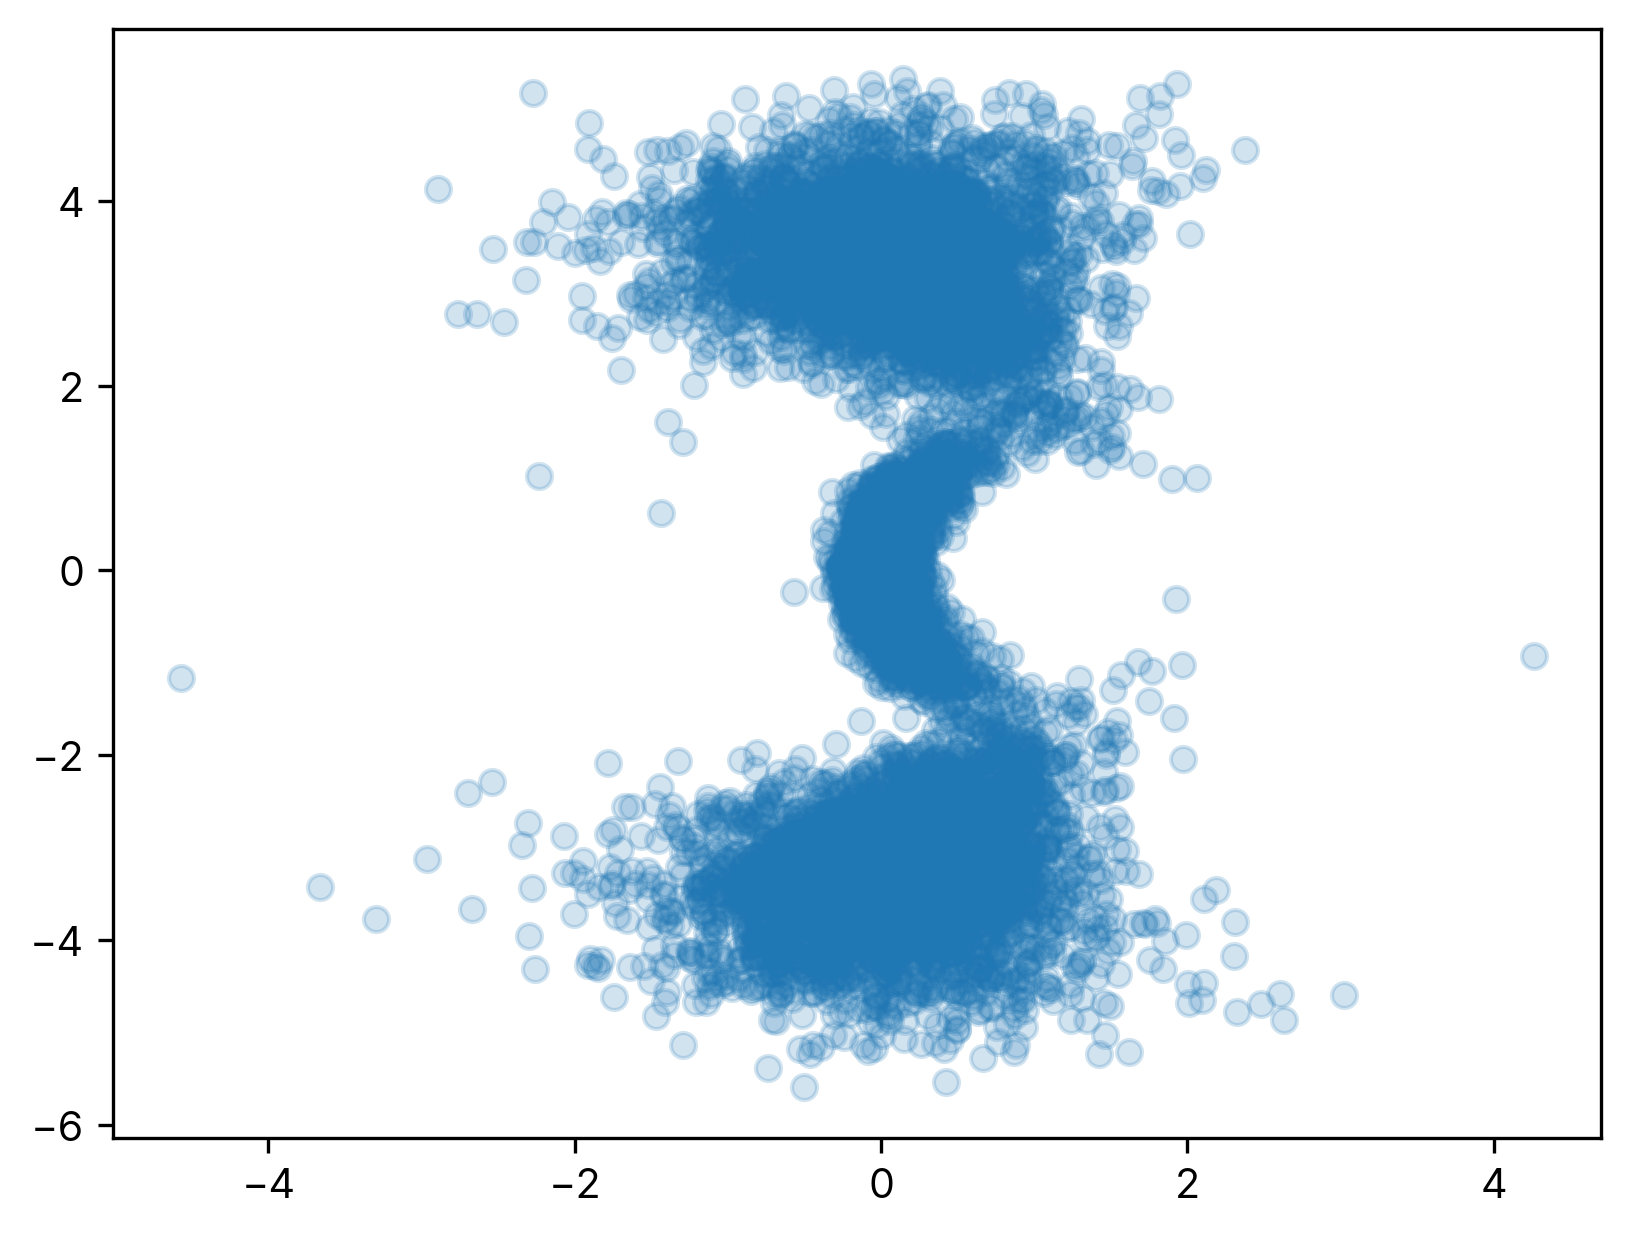

In [8]:
plt.scatter(Z_env[:,0], Z_env[:,1], alpha=0.2)

# Use Parametrized Conformal Regions for Prediction

In [9]:
from conformal_region_designer.conformity_optimizer import ConformalRegion
DELTA = 0.90
BW_FACTOR = 0.2

In [10]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


In [11]:
## Calculate benchmark CP region, based on L2 norm
bcp_scores_cal_one = np.linalg.norm(Z_cal_one, axis=1)
bcp_scores_cal_two = np.linalg.norm(Z_cal_two, axis=1)
bcp_scores_cal = np.concatenate([bcp_scores_cal_one, bcp_scores_cal_two])
bcp_scores_test = np.linalg.norm(Z_test, axis=1)
bcp_conformal_quantile = conformalized_quantile(len(bcp_scores_cal), DELTA)
bcp_conformal_bound = np.quantile(bcp_scores_cal, bcp_conformal_quantile)
print(f'Conformal Quantile: {bcp_conformal_quantile:.2f}')
test_coverage = (bcp_scores_test < bcp_conformal_bound).mean()
print(f'Coverage on test set: {test_coverage:.4f}')
print(f'Conformal Bound: {bcp_conformal_bound:.2f} | Area: {np.pi * bcp_conformal_bound**2:.2f}')

Conformal Quantile: 0.90
Coverage on test set: 0.9112
Conformal Bound: 4.12 | Area: 53.41


## Convex Hull

In [12]:
from conformal_region_designer.density_estimation import KDE
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "convexhull", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
cvxpcr = pcr

Total Weight Sum: 0.9827644682689719


Test Coverage:  0.9049190161967606


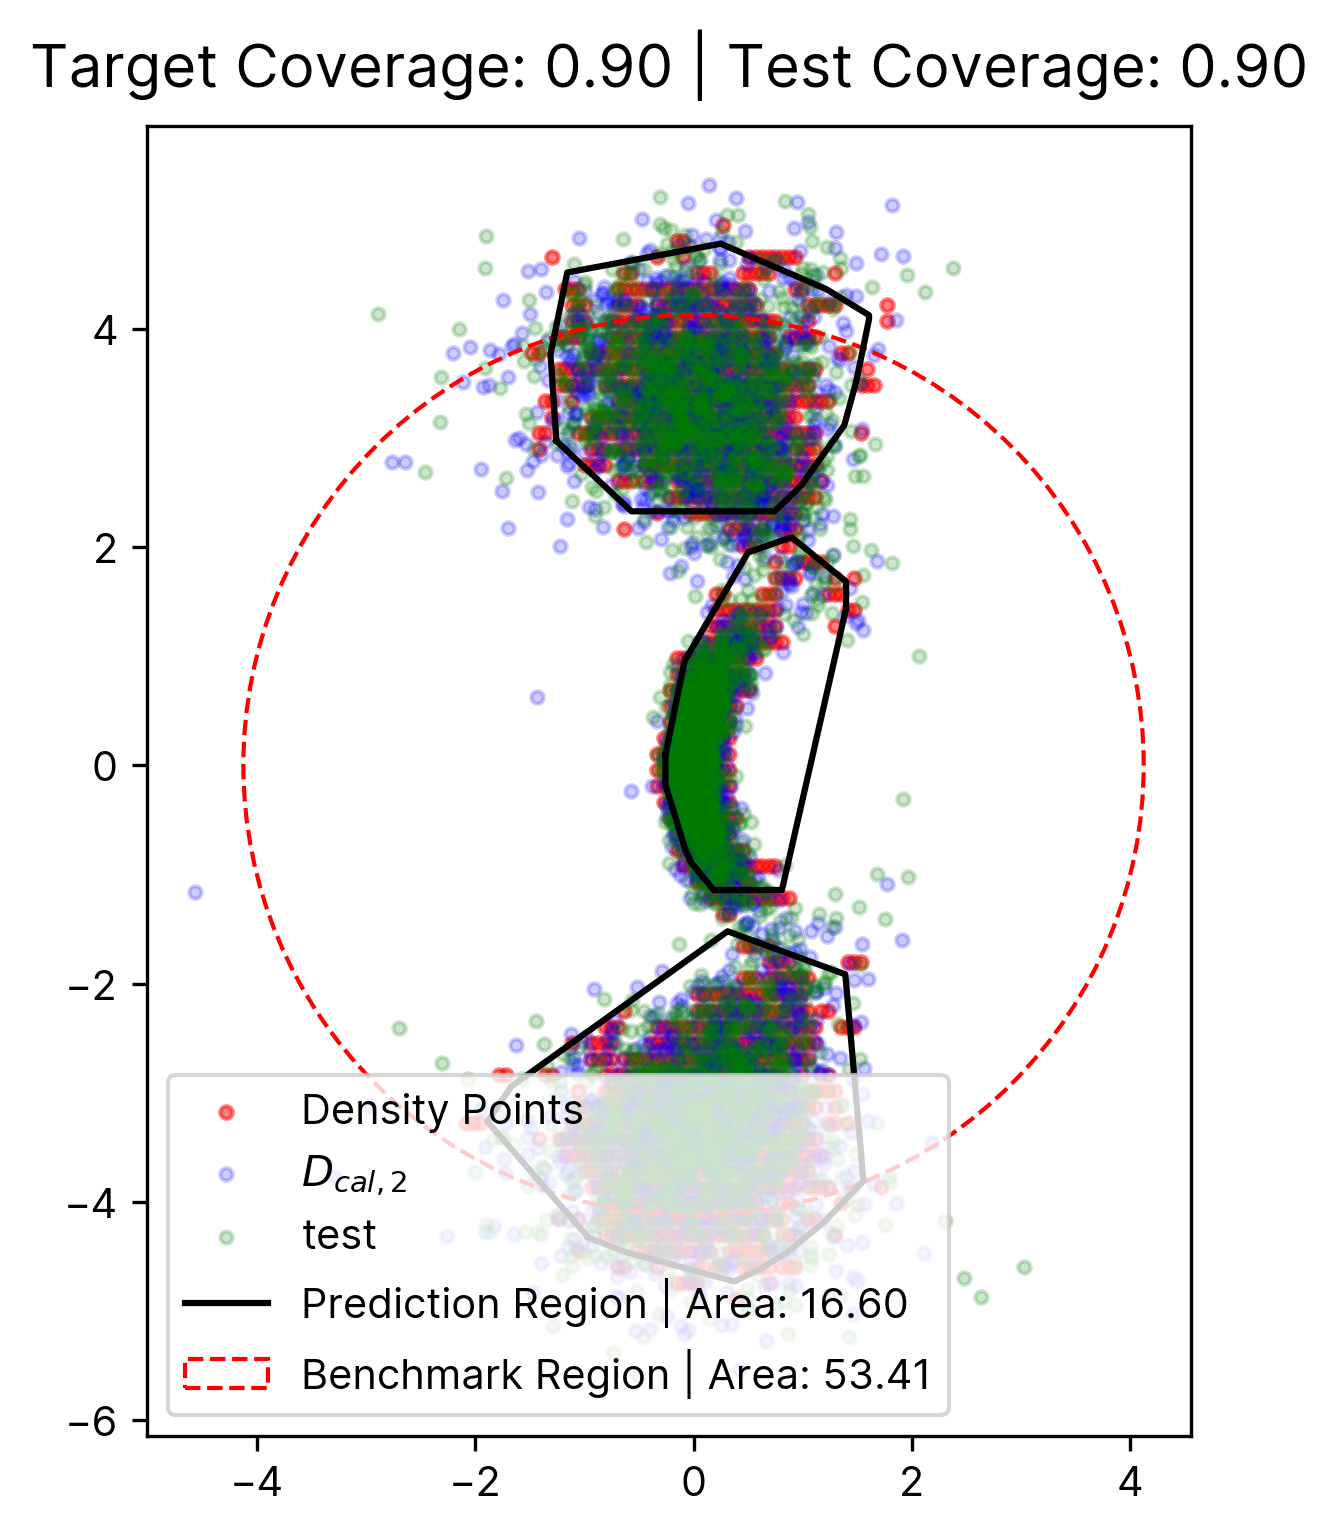

In [13]:
scores = cvxpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
cvx_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
ax.scatter(pcr.density_points[:, 0], pcr.density_points[:, 1], color="red", marker=".", label="Density Points", alpha=0.5)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}');


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

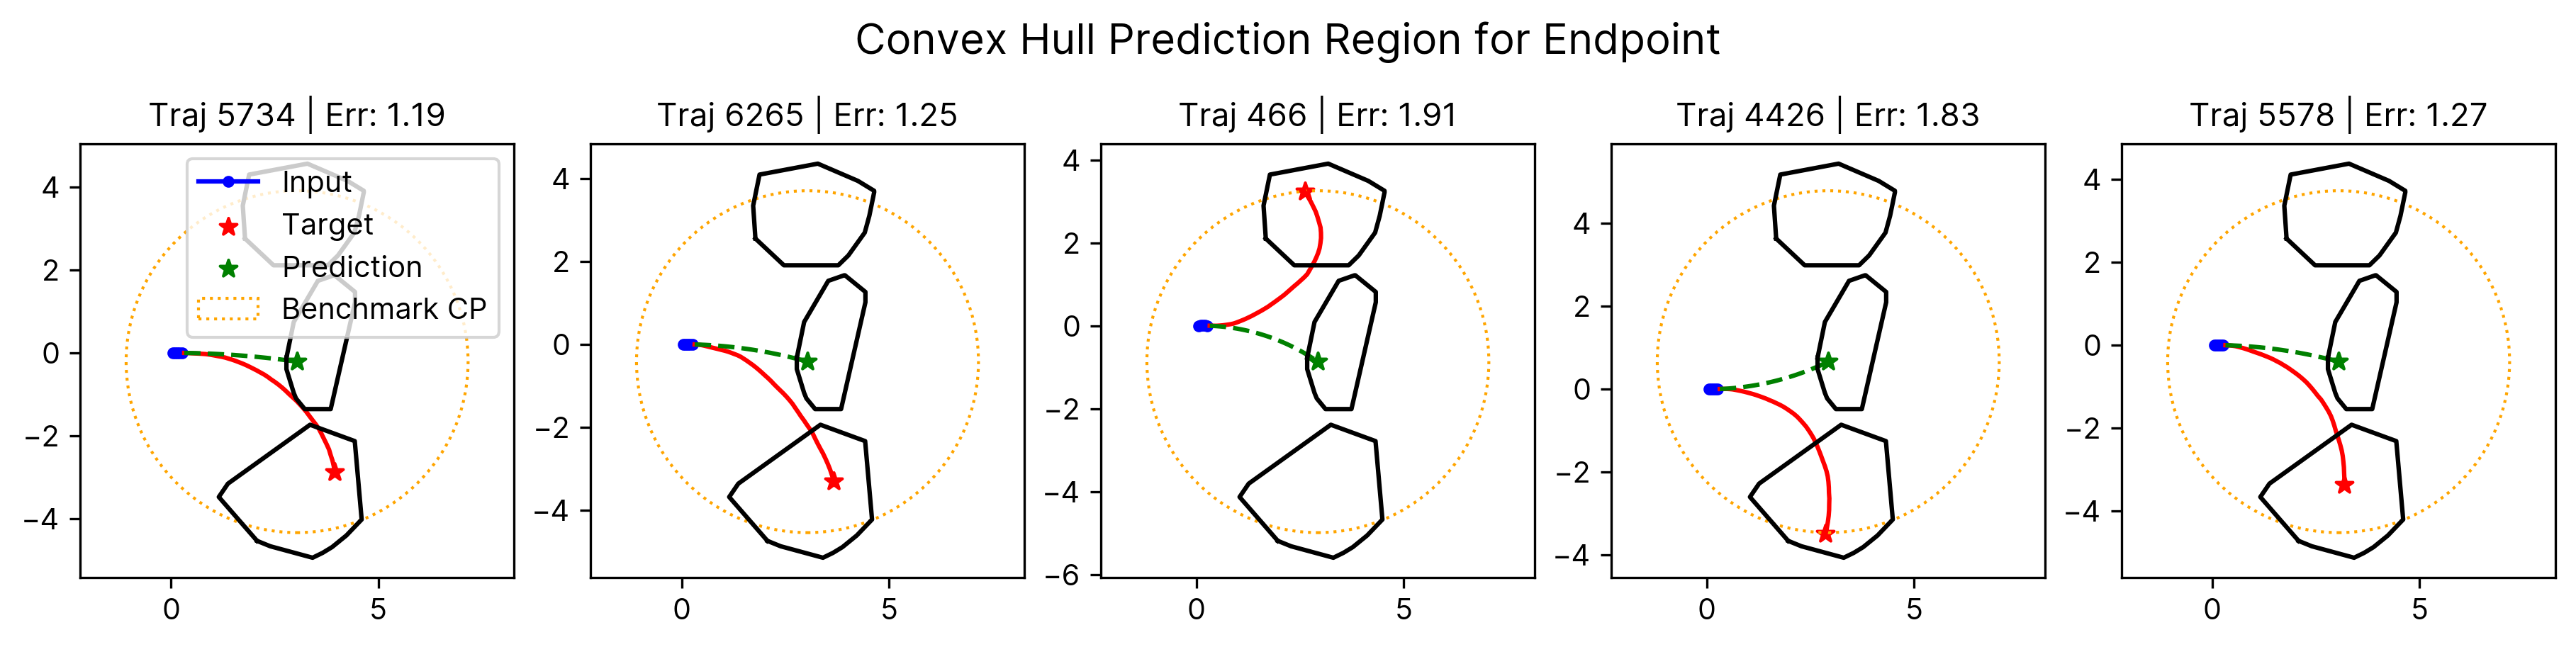

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in cvxpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/10000 [00:00<?, ?it/s]

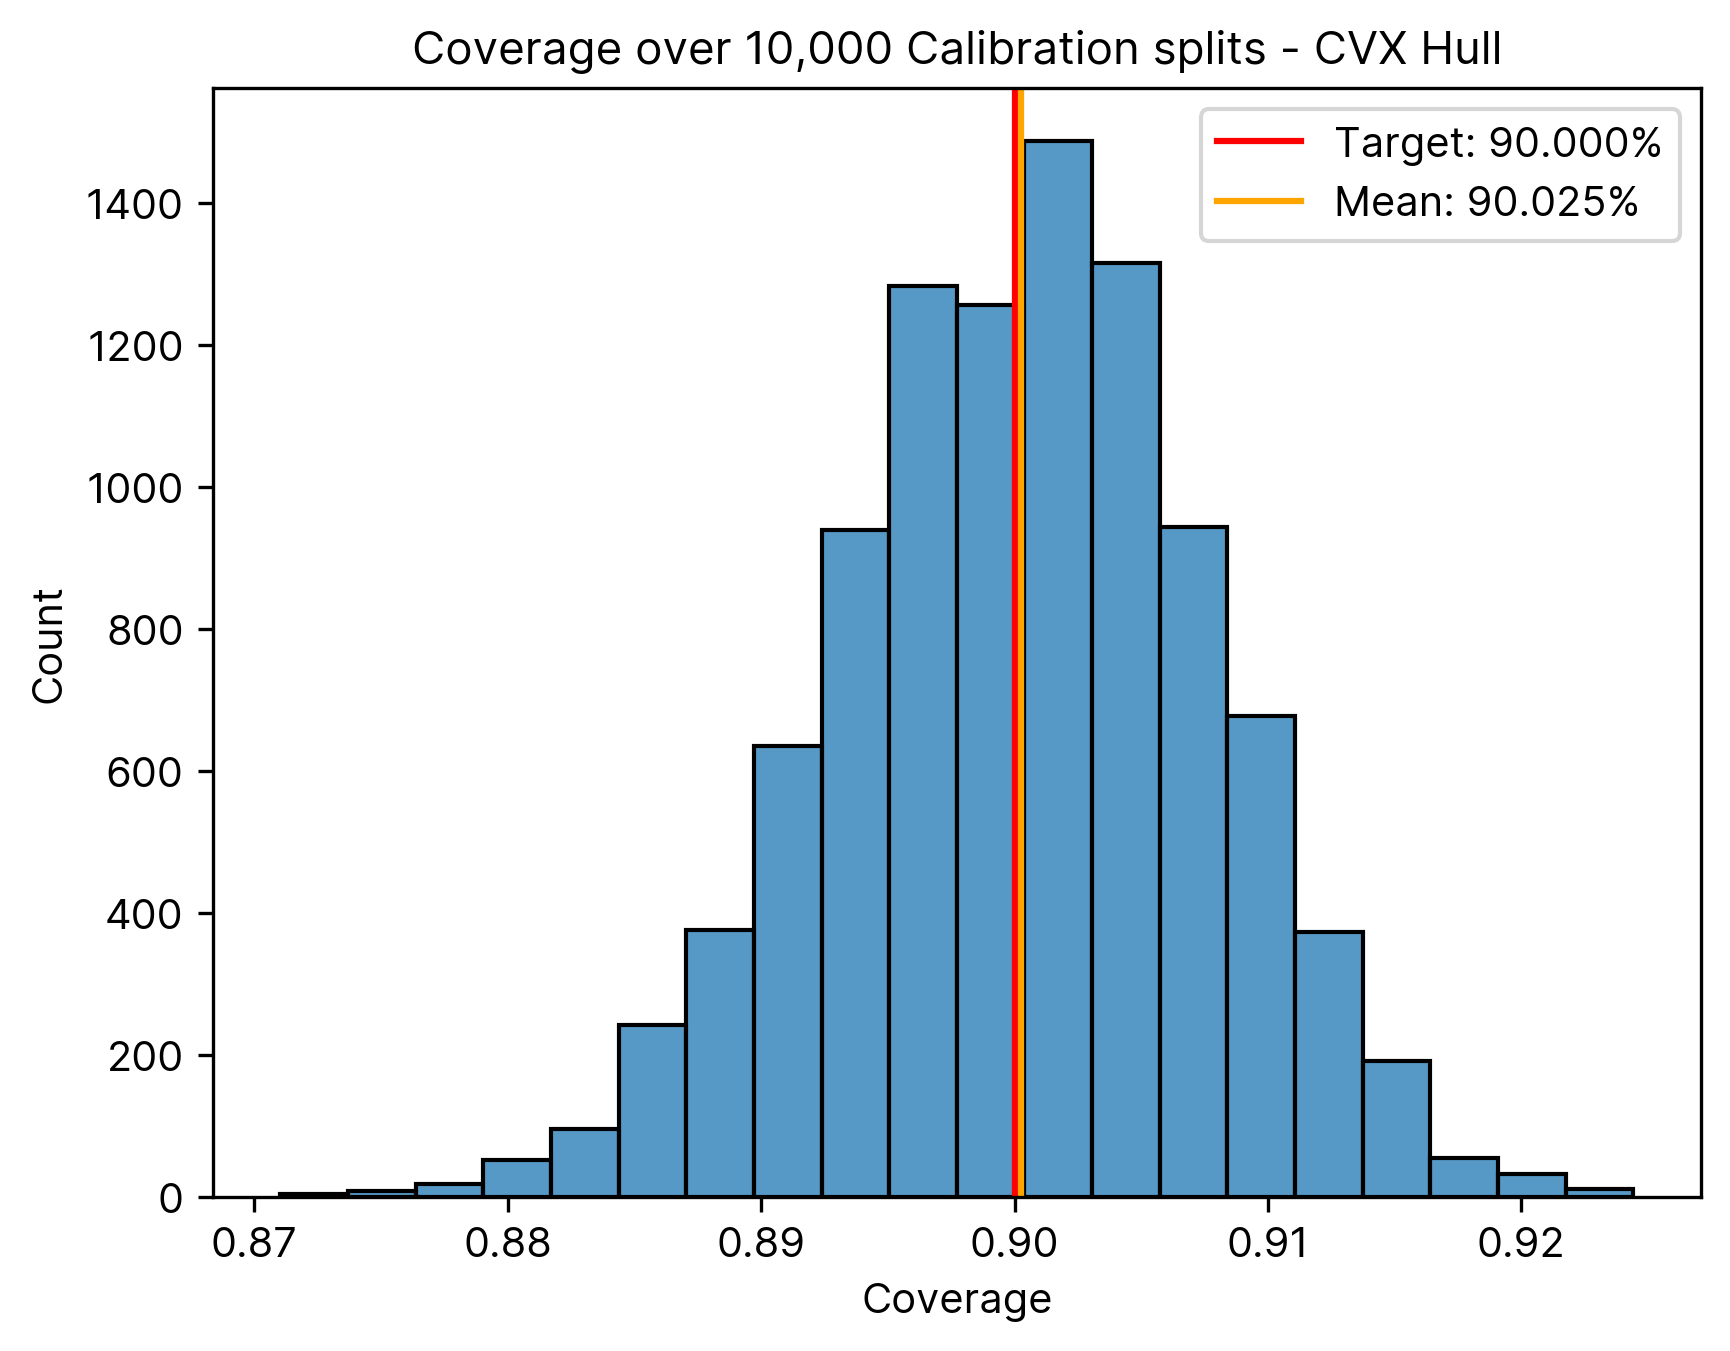

In [15]:
cvxcoverages = shuffle_split_testing(deepcopy(pcr), Z_eval, 10000, 0.5, 42)

sns.histplot(cvxcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(cvxcoverages), color="orange", label=f"Mean: {np.mean(cvxcoverages):.3%}")
plt.title("Coverage over 10,000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [16]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "hyperrectangle", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
hrpcr = pcr

Total Weight Sum: 0.9827644682689719


Test Coverage:  0.9352129574085183


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.94')

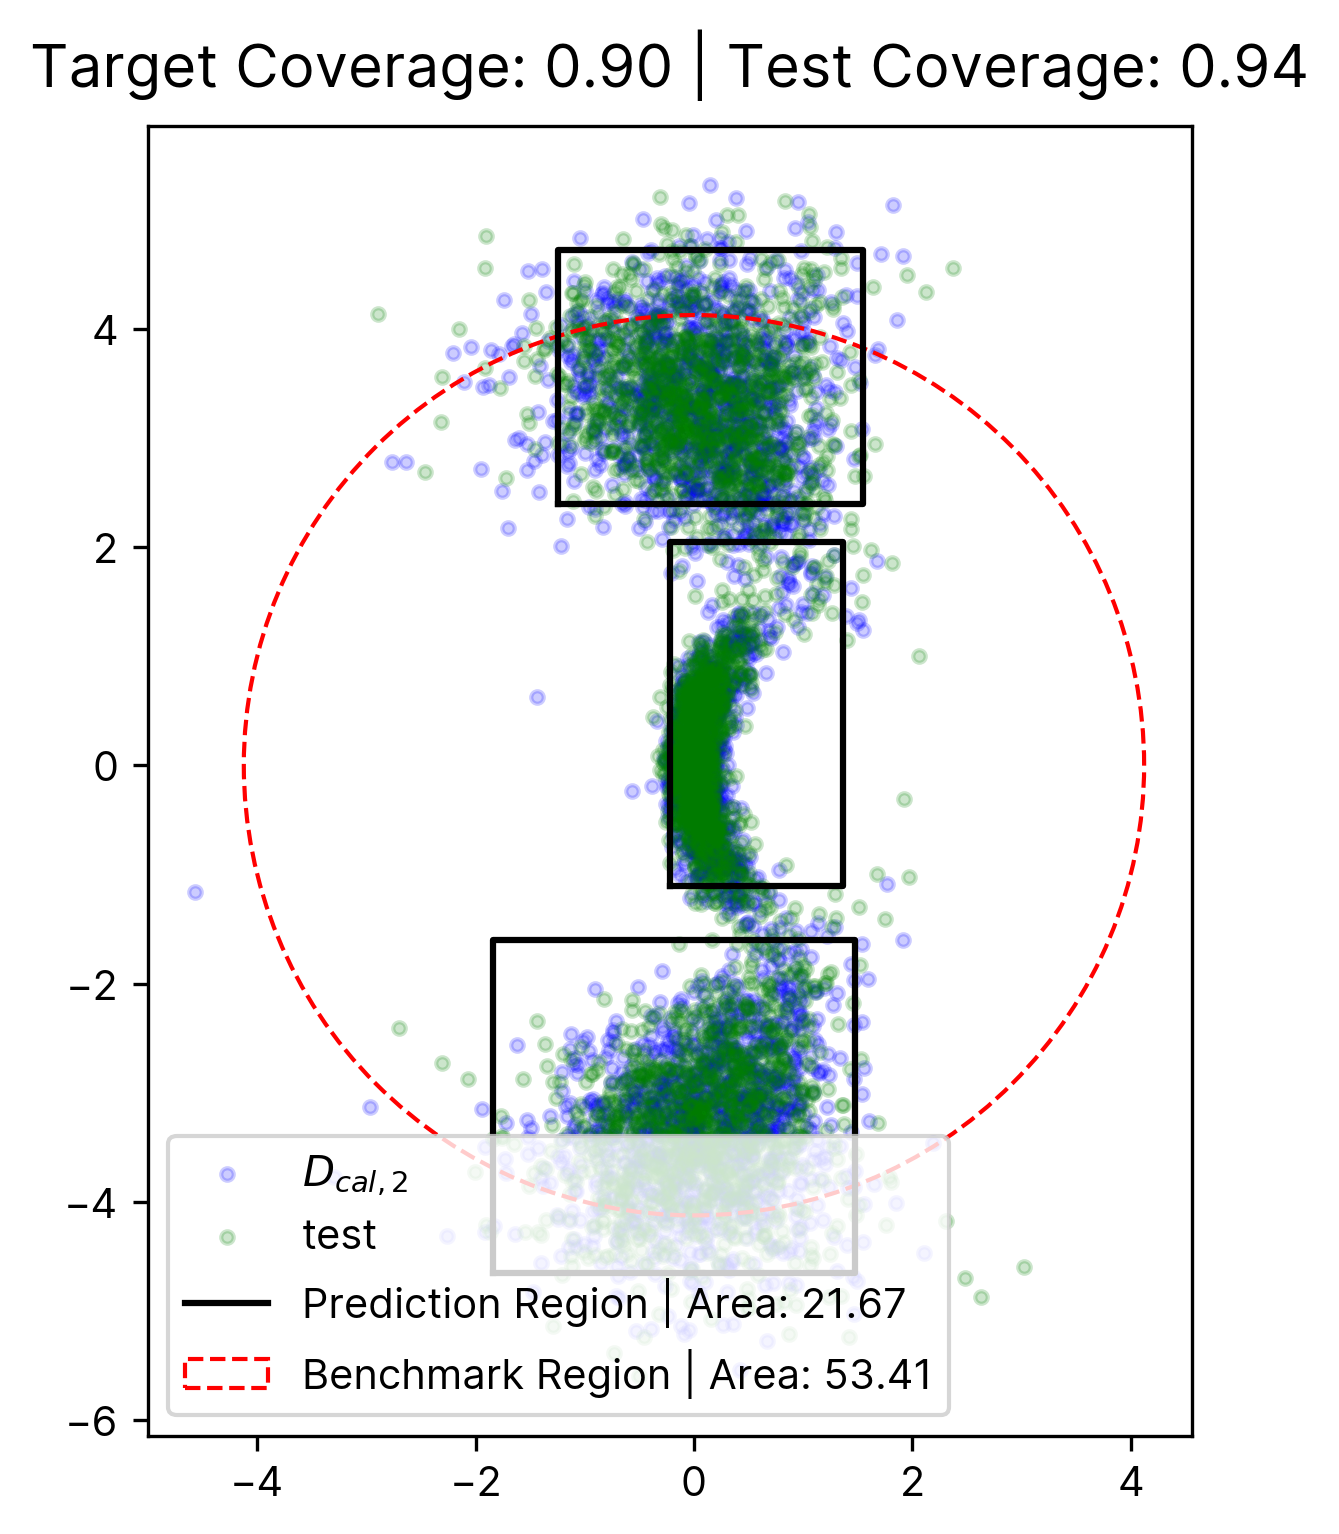

In [17]:
scores = hrpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
hrc_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Hyperrectangle Prediction Region for Endpoint')

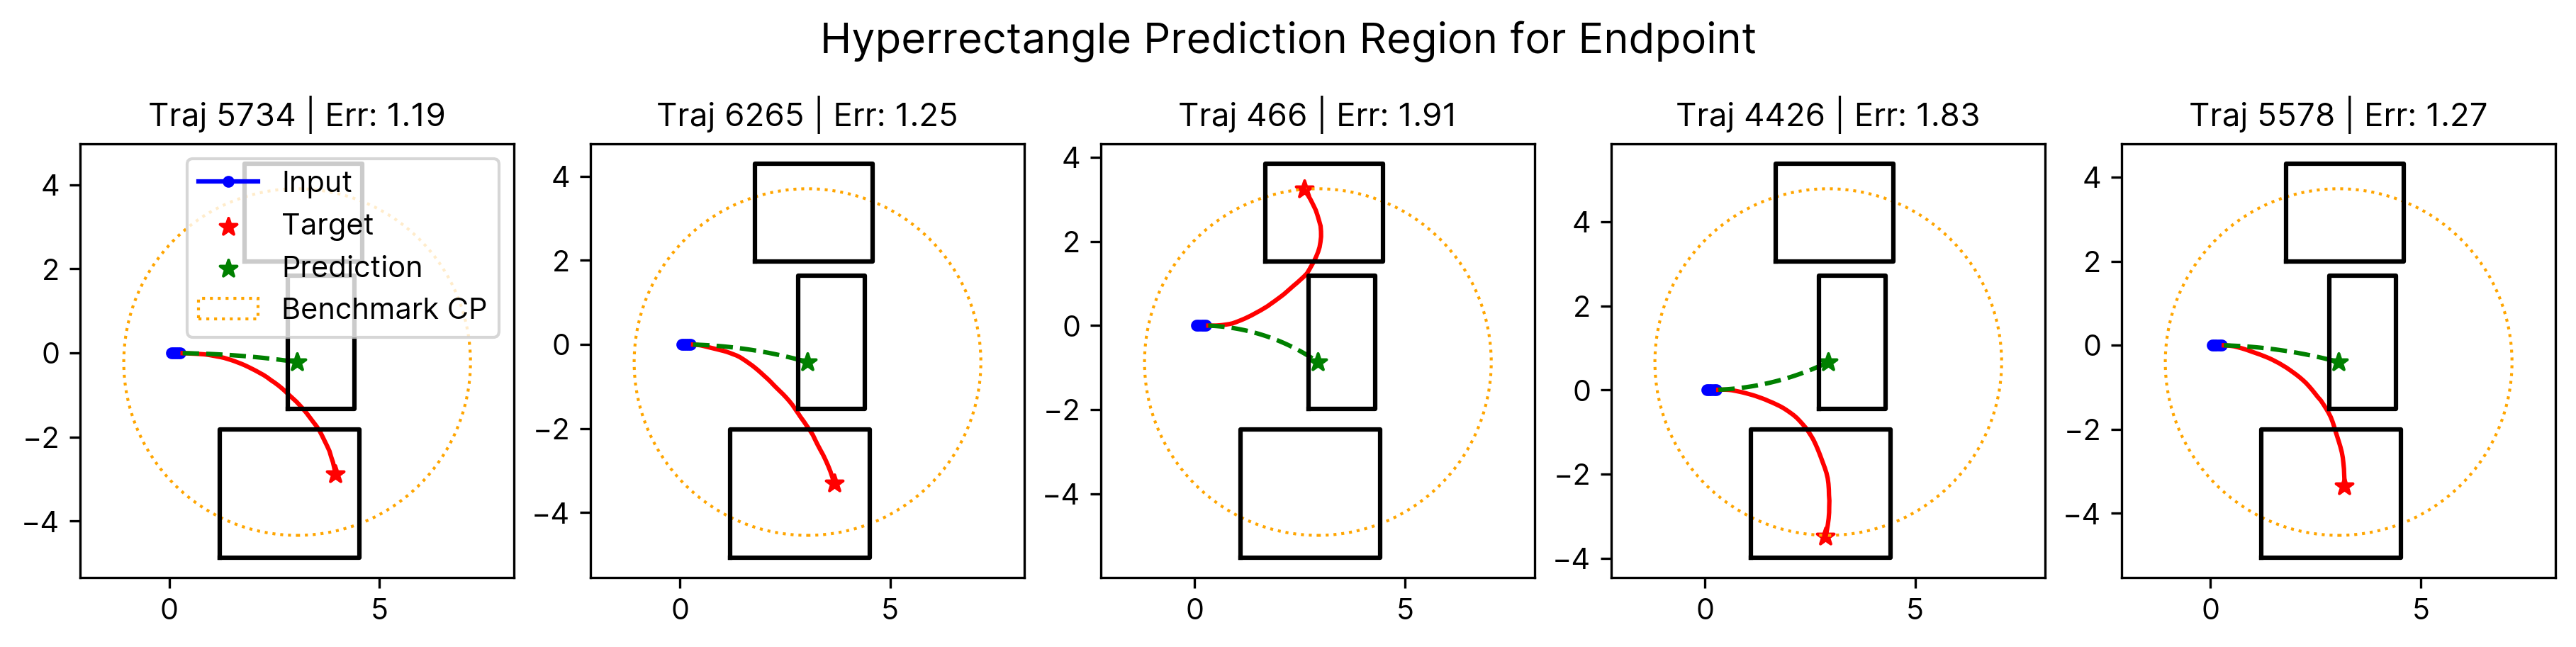

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in hrpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

  0%|          | 0/10000 [00:00<?, ?it/s]

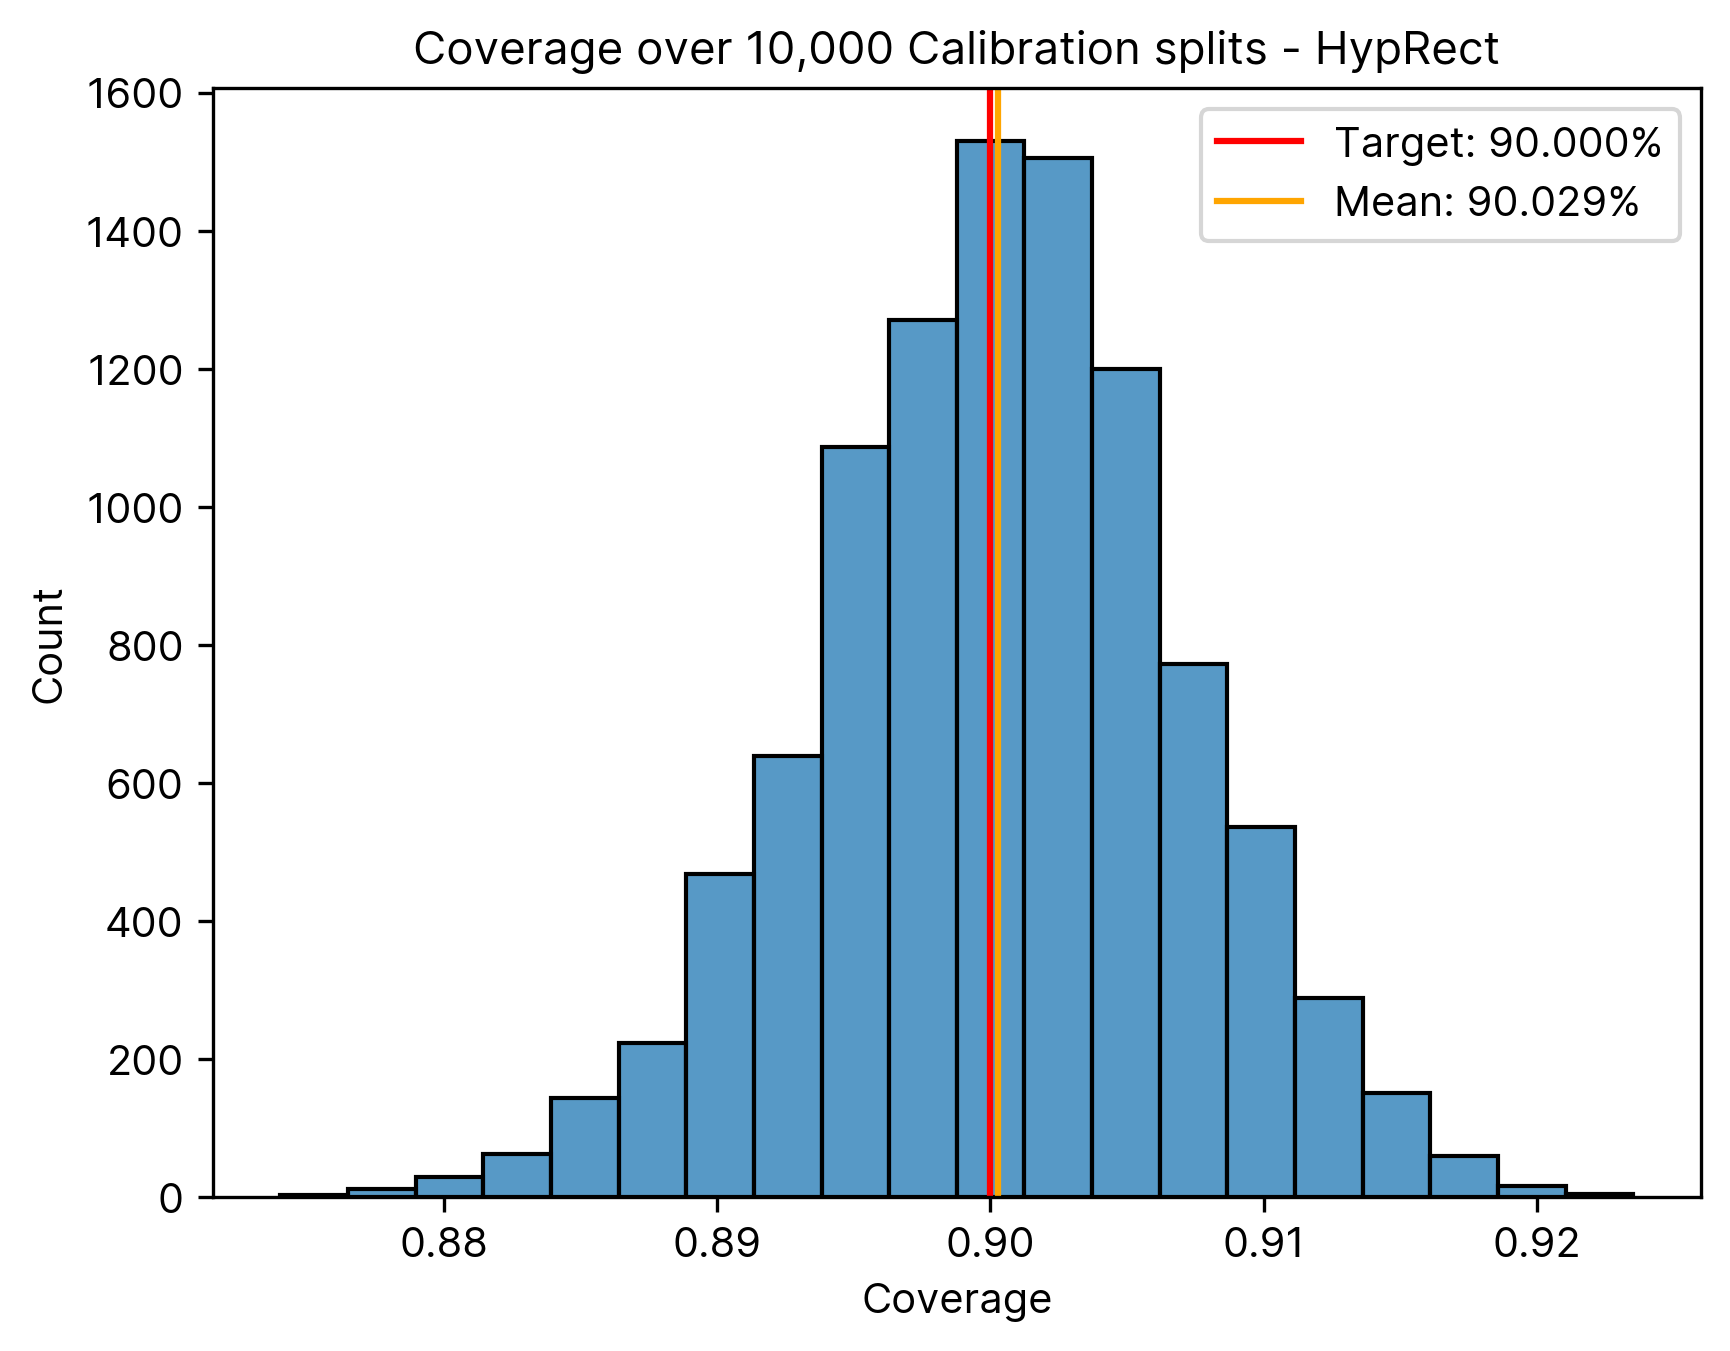

In [19]:
hrcoverages = shuffle_split_testing(deepcopy(pcr), Z_eval, 10_000, 0.5, 42)
sns.histplot(hrcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(hrcoverages), color="orange", label=f"Mean: {np.mean(hrcoverages):.3%}")
plt.title("Coverage over 10,000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [20]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "ellipse", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
ellpcr = pcr
print(pcr.normalizing_constant)
print(pcr.normalizing_constant.shape)

Total Weight Sum: 0.9827644682689719
[0.06758815 0.04644327 0.15244896]
(3,)


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.94')

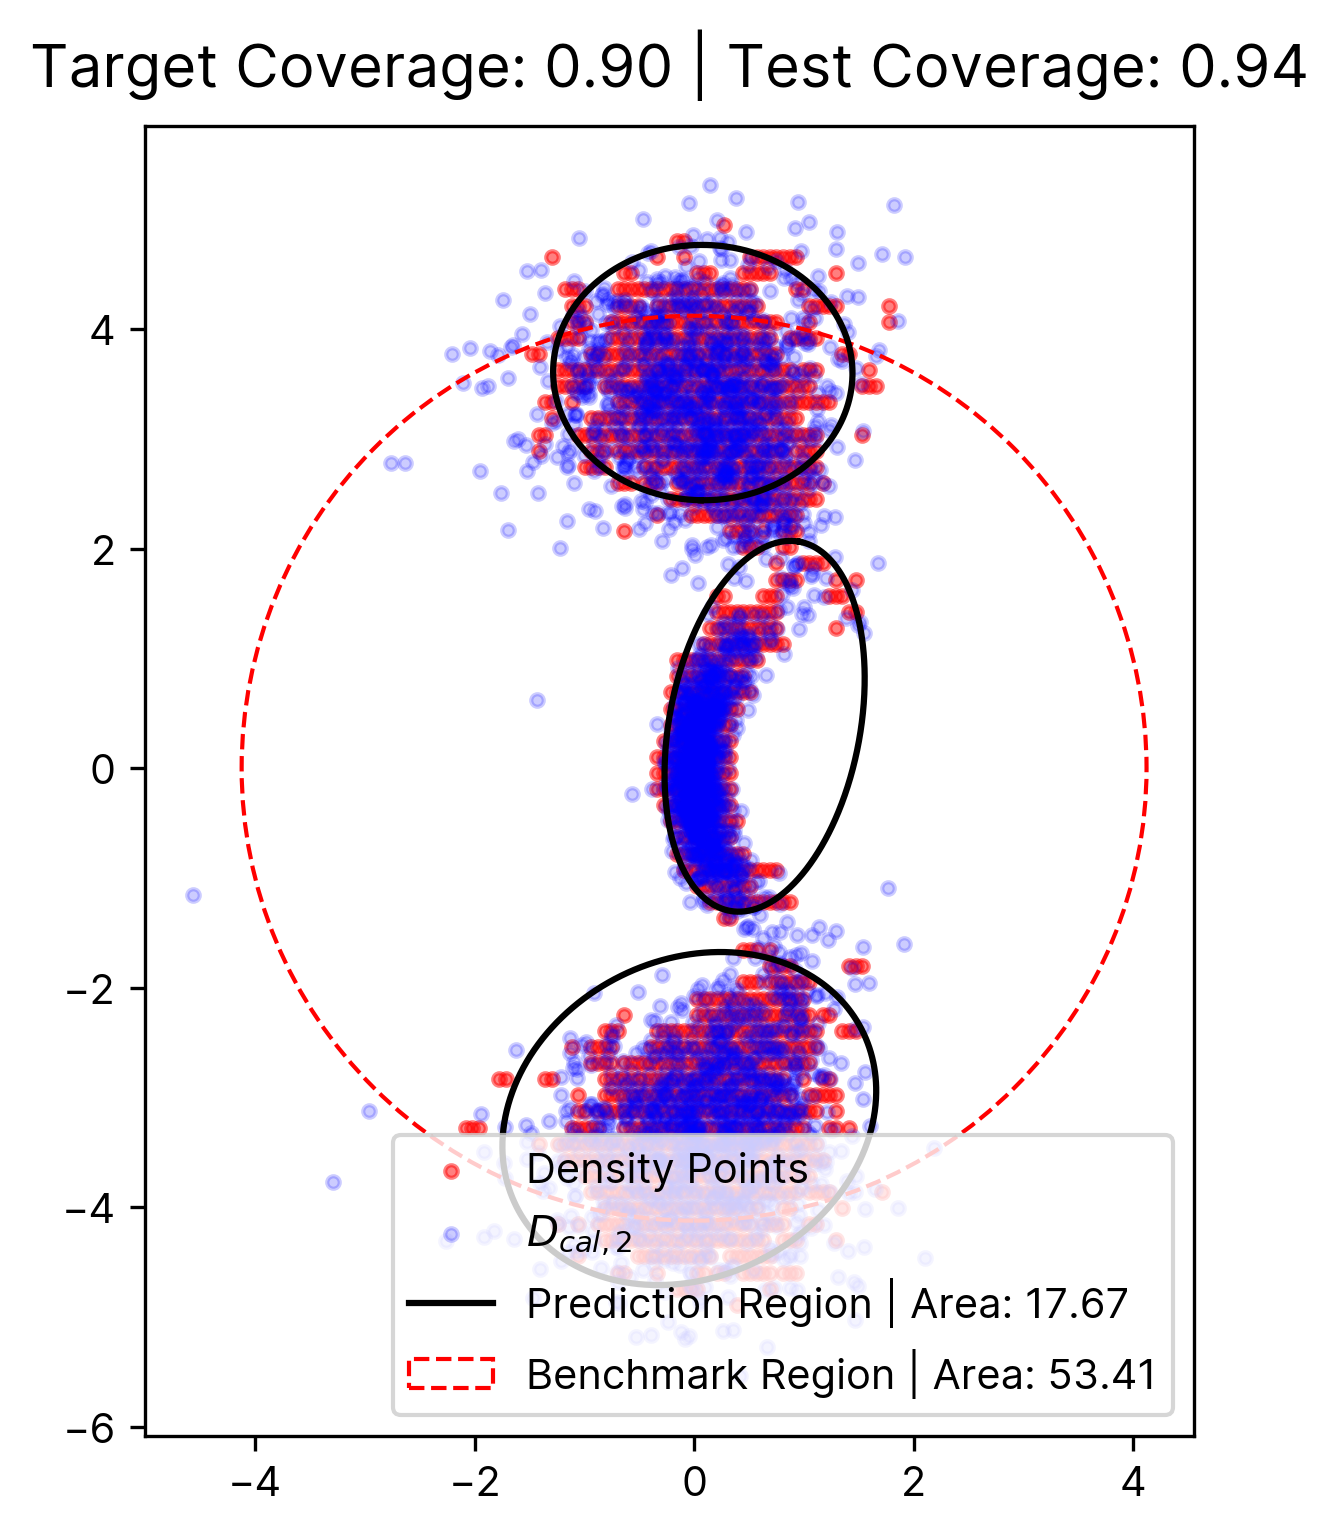

In [21]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
ax.scatter(pcr.density_points[:, 0], pcr.density_points[:, 1], color="red", marker=".", label="Density Points", alpha=0.5)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')

Test Coverage:  0.9085182963407319


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.91')

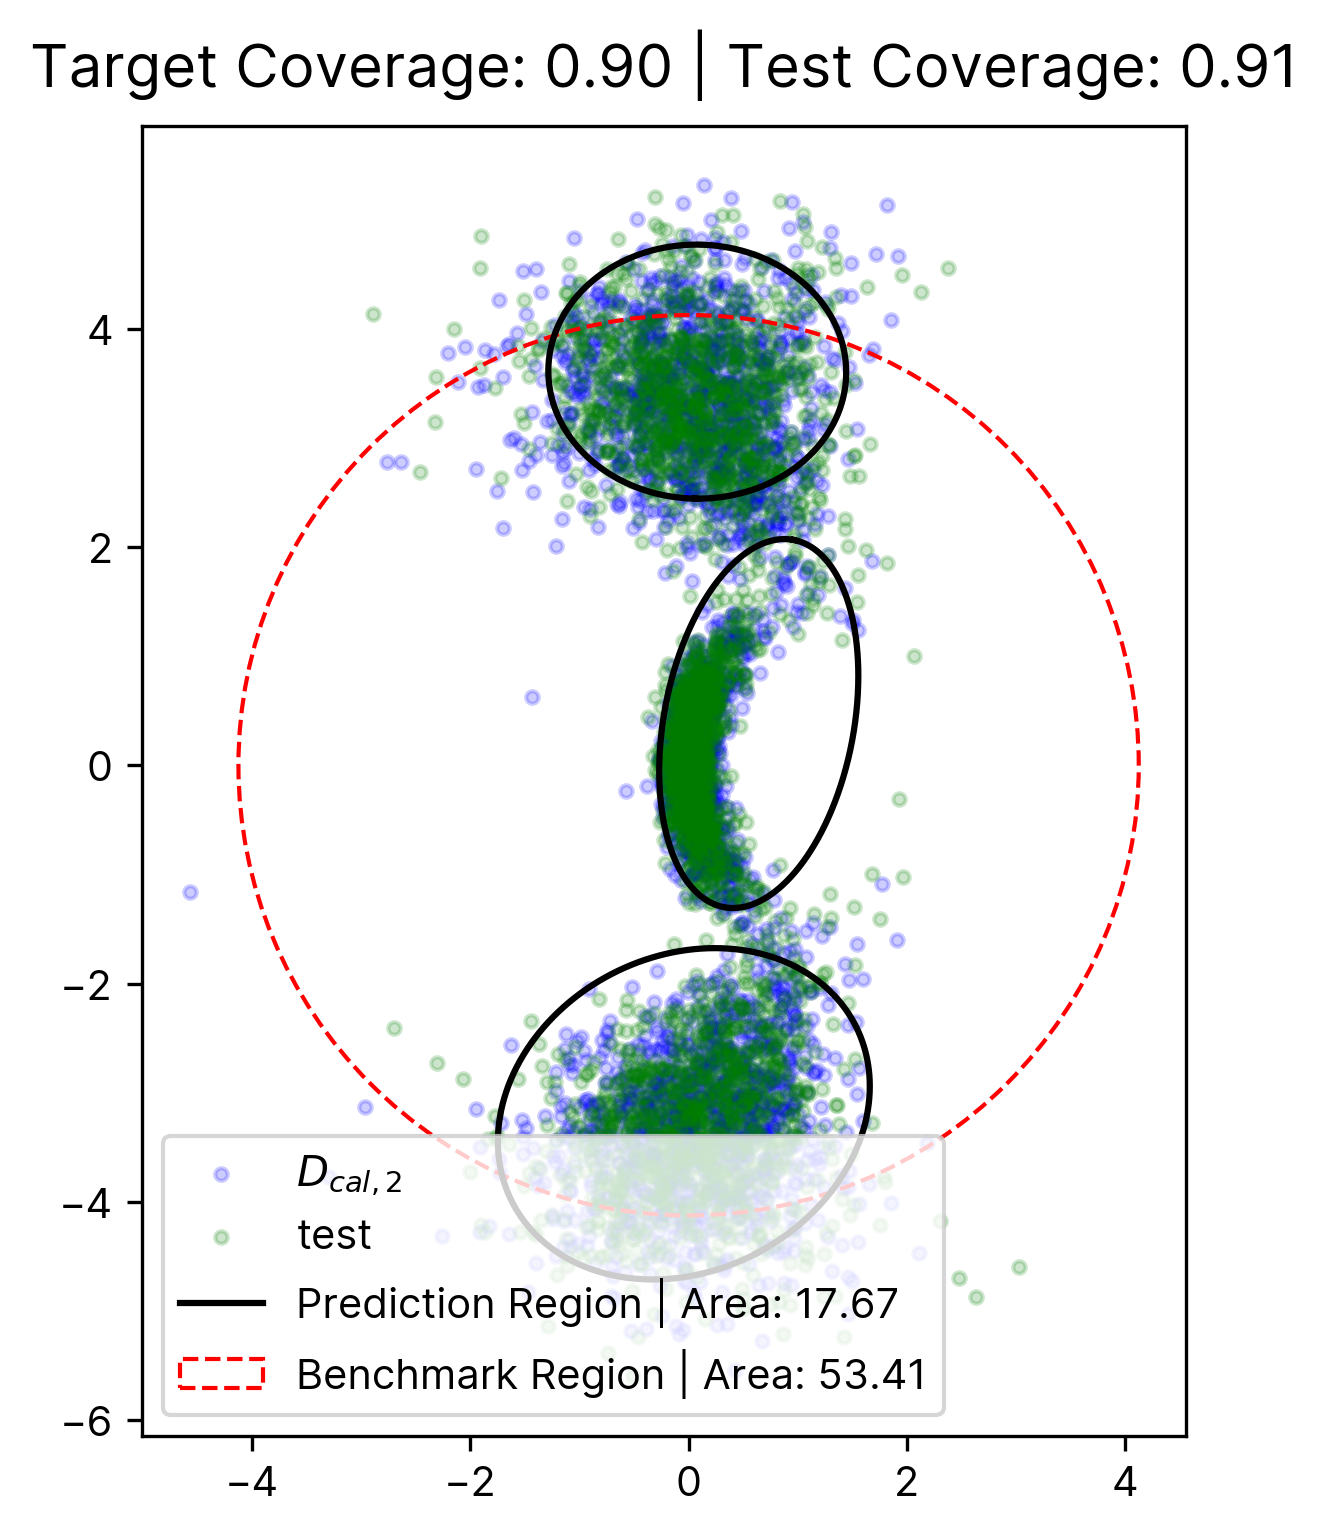

In [22]:
scores = ellpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
ell_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

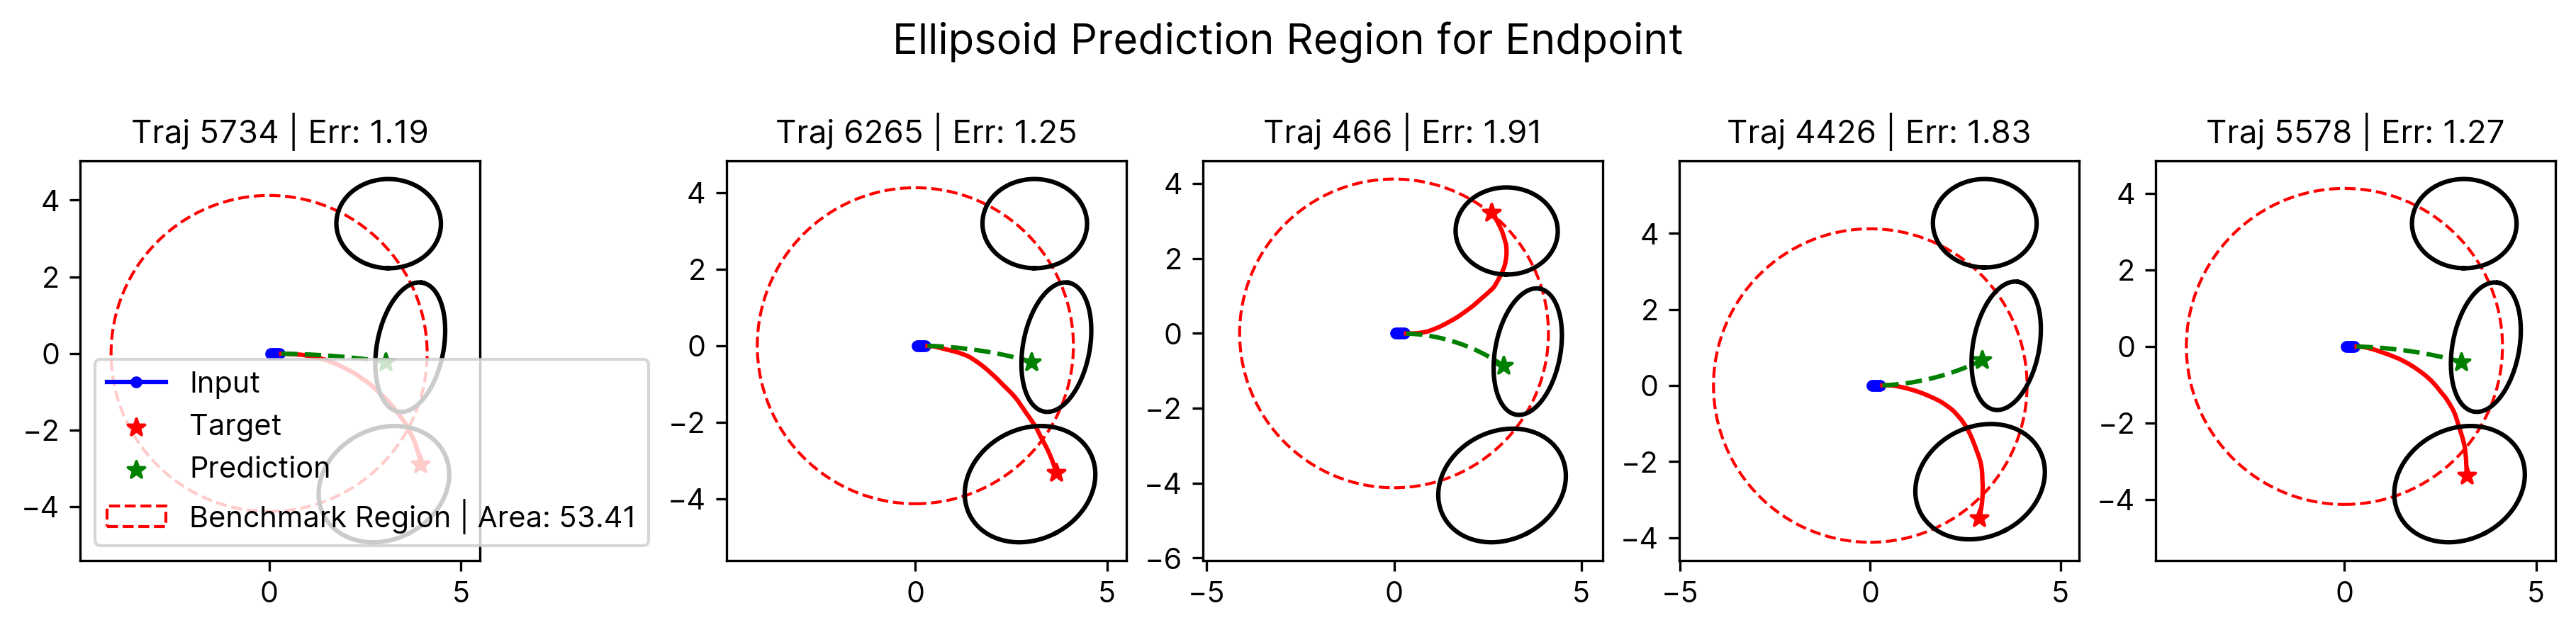

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in ellpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

  0%|          | 0/10000 [00:00<?, ?it/s]

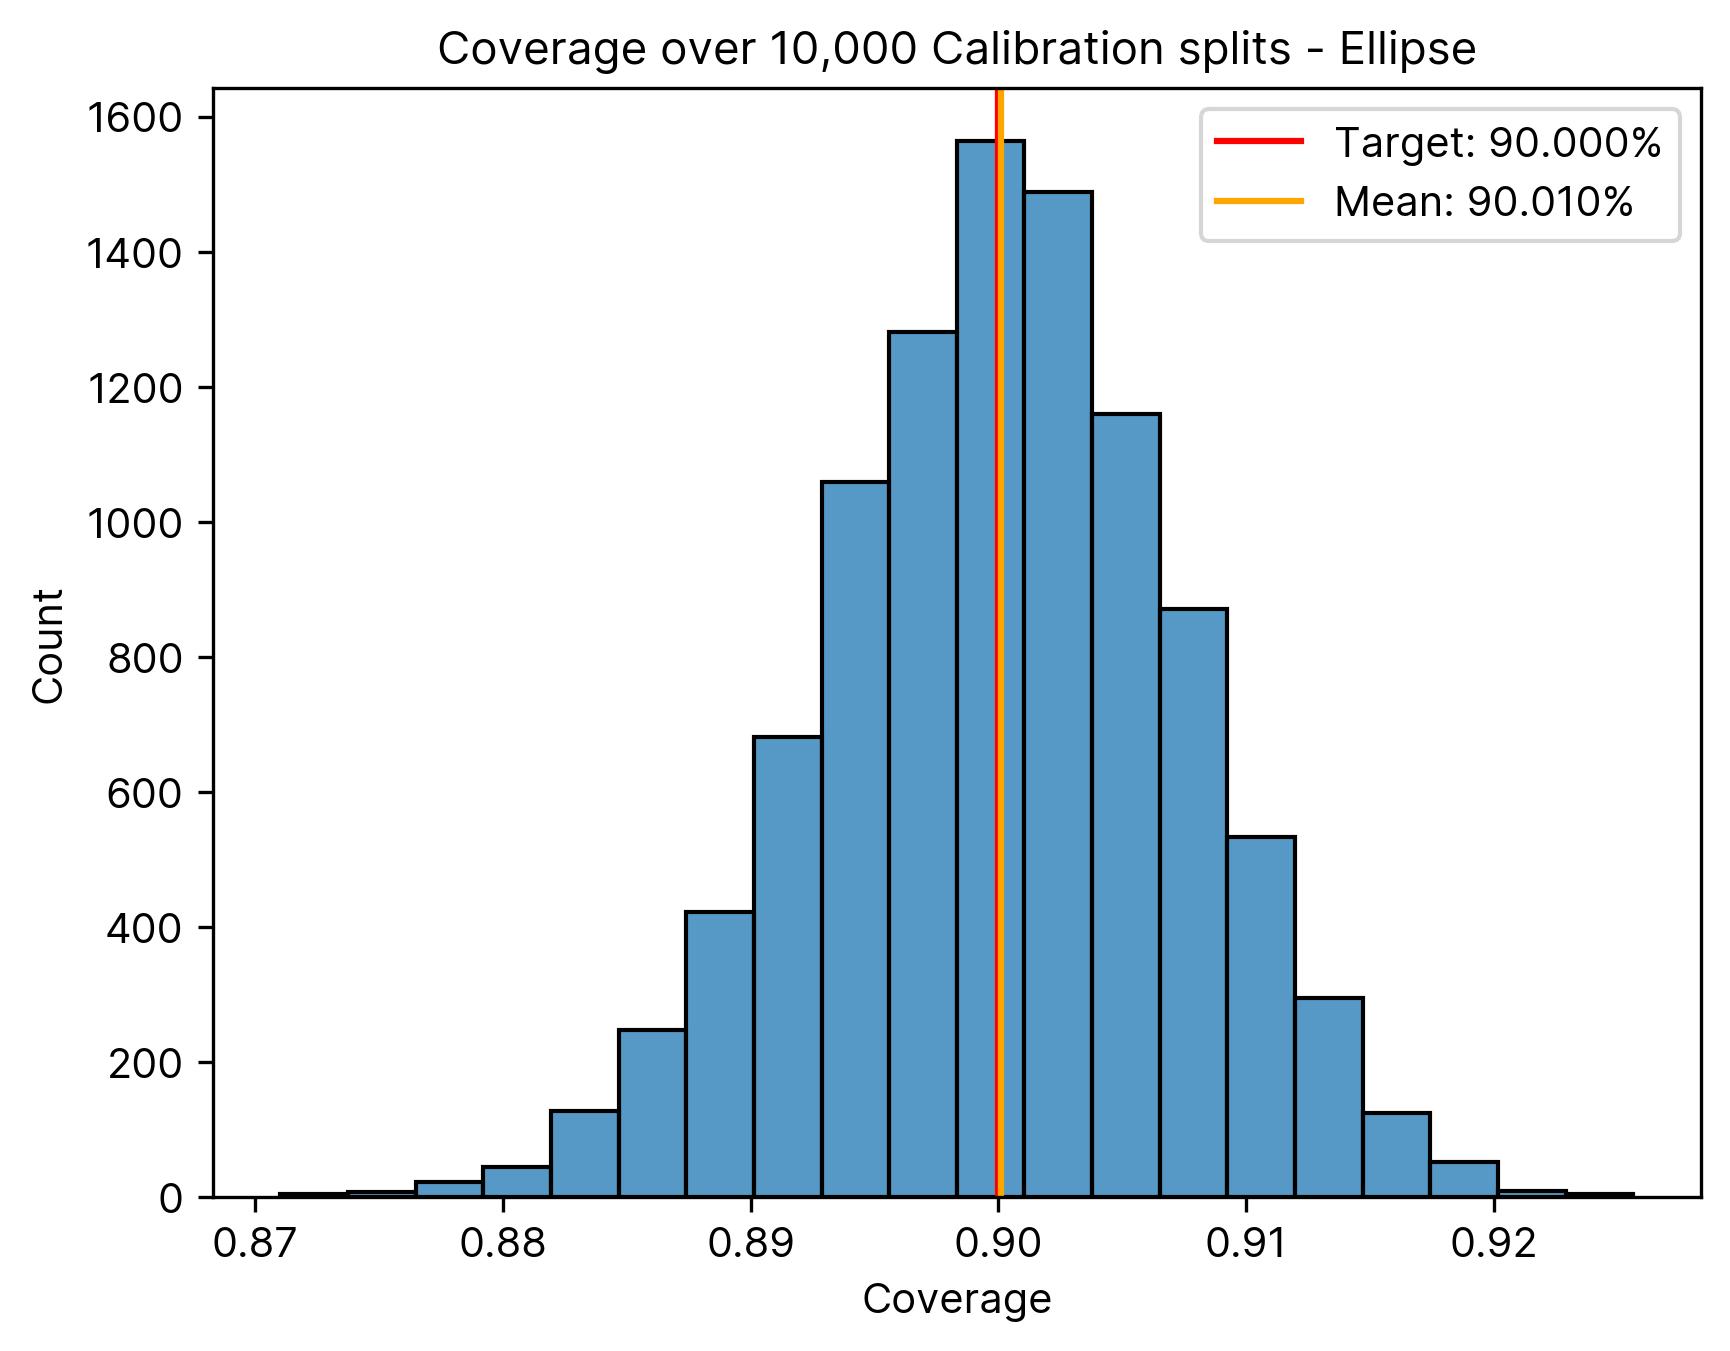

In [24]:
ellcoverages = shuffle_split_testing(deepcopy(pcr), Z_eval, 10_000, 0.5, 42)
sns.histplot(ellcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(ellcoverages), color="orange", label=f"Mean: {np.mean(ellcoverages):.3%}")
plt.title("Coverage over 10,000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

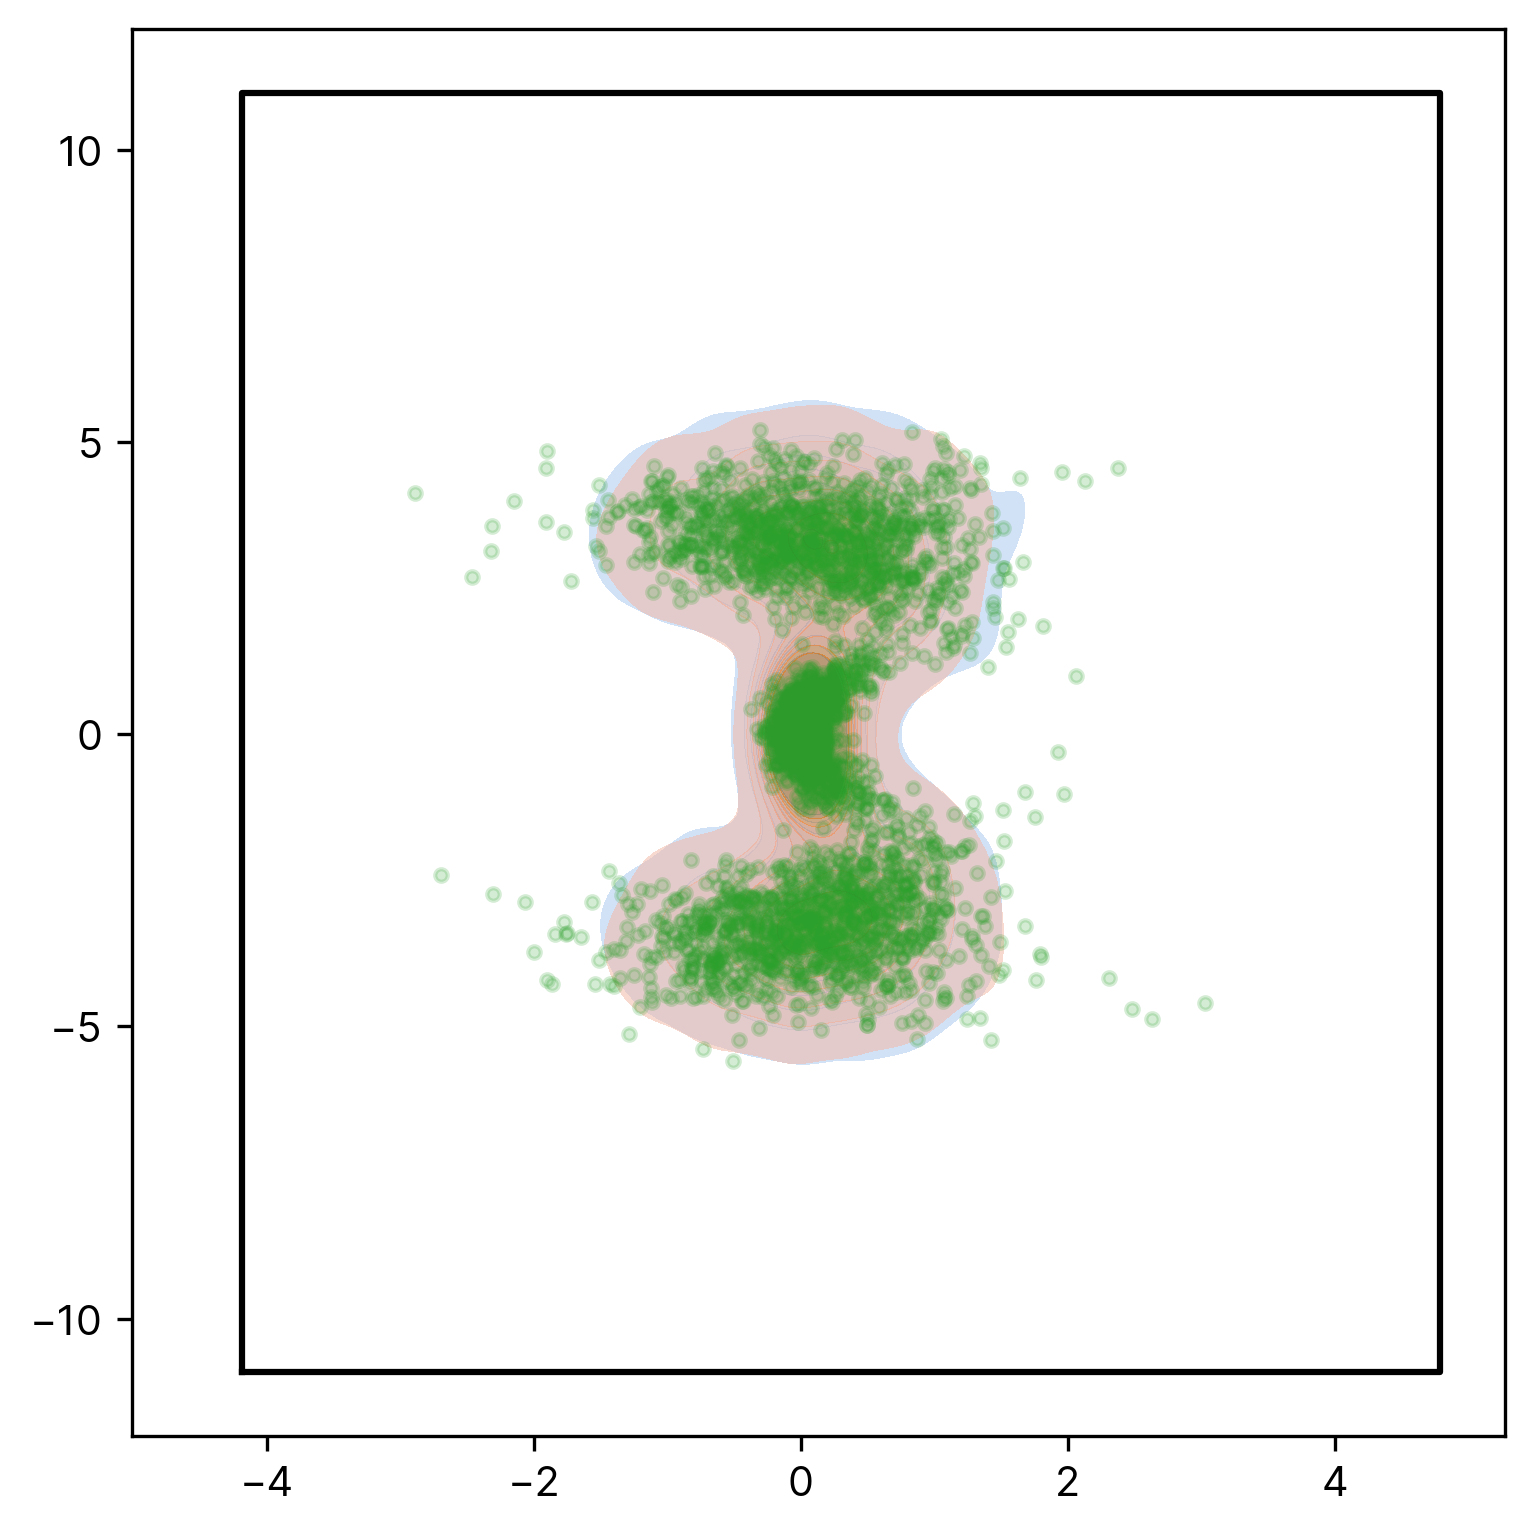

In [25]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
sns.kdeplot(x=Z_cal_one[:,0], y=Z_cal_one[:, 1], fill=True, ax=ax, label='Calibration Set 1', alpha=0.5)
sns.kdeplot(x=Z_cal_two[:,0], y=Z_cal_two[:, 1], fill=True, ax=ax, label='Calibration Set 2', alpha=0.5)
plt.scatter(Z_test[:,0], Z_test[:,1], label='Test Set', alpha=0.2, marker='.')
# Plot the density estimator min and max
ax.plot(
    [pcr.de.min[0], pcr.de.min[0], pcr.de.max[0], pcr.de.max[0], pcr.de.min[0]],
    [pcr.de.min[1], pcr.de.max[1], pcr.de.max[1], pcr.de.min[1], pcr.de.min[1]],
    color="black",
)

Text(0.5, 0.98, 'Vehicle Trajectory Prediction Regions')

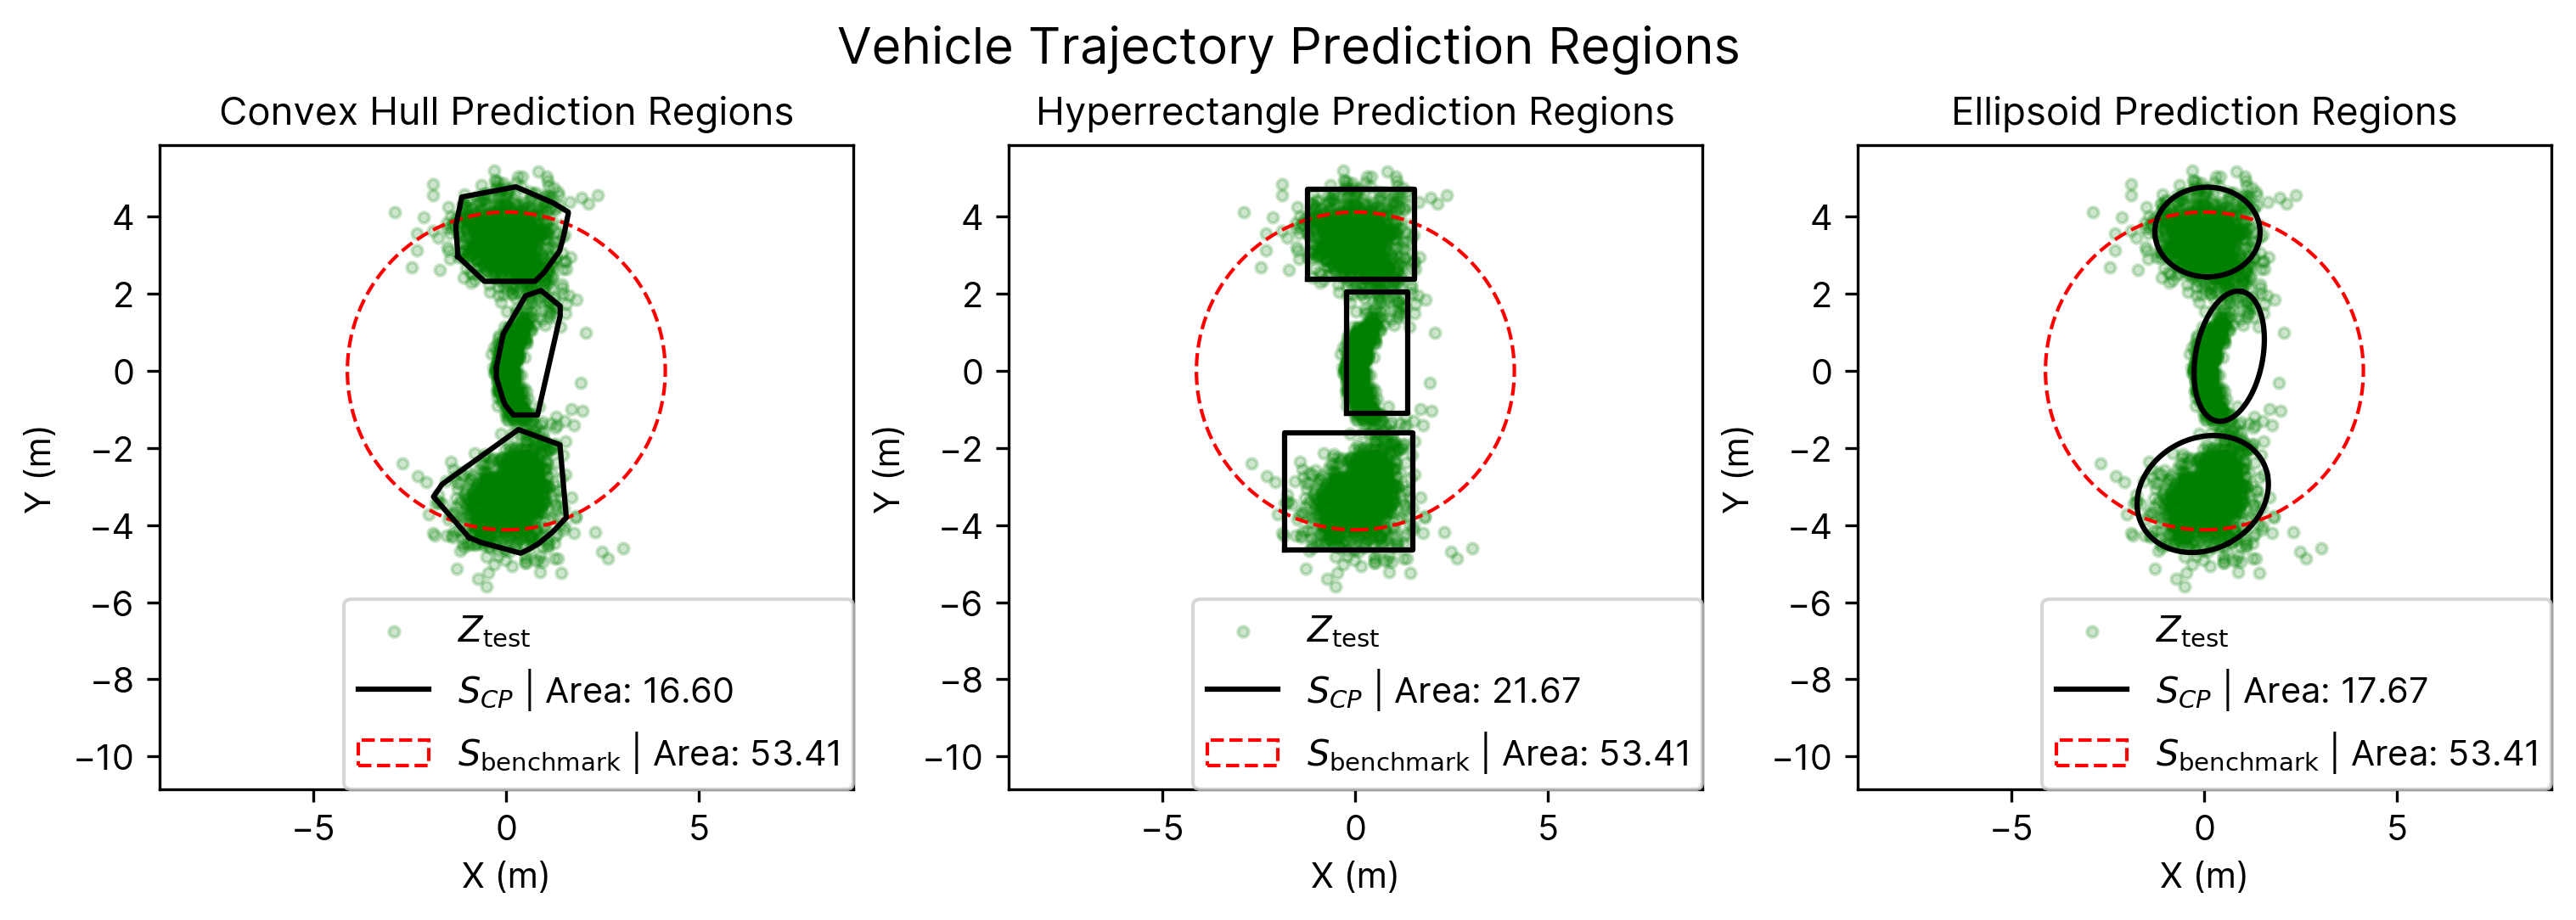

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), constrained_layout=True)
X_LIMS = [-9, 9]
Y_LIMS = [-15, 10]
# On the first plot, show the convex hull
#ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
axs[0].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[0].set_aspect("equal", adjustable='datalim')
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(axs[0], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[0])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[0].add_patch(bcp_cir)
axs[0].legend(loc='lower right', borderaxespad=0.)
axs[0].set_xlabel("X (m)")
axs[0].set_ylabel("Y (m)")
axs[0].set_xlim(X_LIMS)
axs[0].set_ylim(Y_LIMS)
axs[0].set_title('Convex Hull Prediction Regions')

axs[1].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[1].set_aspect("equal", adjustable='datalim')
total_area = 0
for i, shape_template in enumerate(hrpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrpcr.shapes) - 1:
        shape_template.plot(axs[1], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[1])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[1].add_patch(bcp_cir)
axs[1].legend(loc='lower right', borderaxespad=0.)
axs[1].set_xlabel("X (m)")
axs[1].set_ylabel("Y (m)")
axs[1].set_xlim(X_LIMS)
axs[1].set_ylim(Y_LIMS)
axs[1].set_title('Hyperrectangle Prediction Regions')

axs[2].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[2].set_aspect("equal", adjustable='datalim')
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(axs[2], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[2])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[2].add_patch(bcp_cir)
axs[2].legend(loc='lower right', borderaxespad=0.)
axs[2].set_xlabel("X (m)")
axs[2].set_ylabel("Y (m)")
axs[2].set_xlim(X_LIMS)
axs[2].set_ylim(Y_LIMS)
axs[2].set_title('Ellipsoid Prediction Regions')

fig.suptitle("Vehicle Trajectory Prediction Regions")

[]

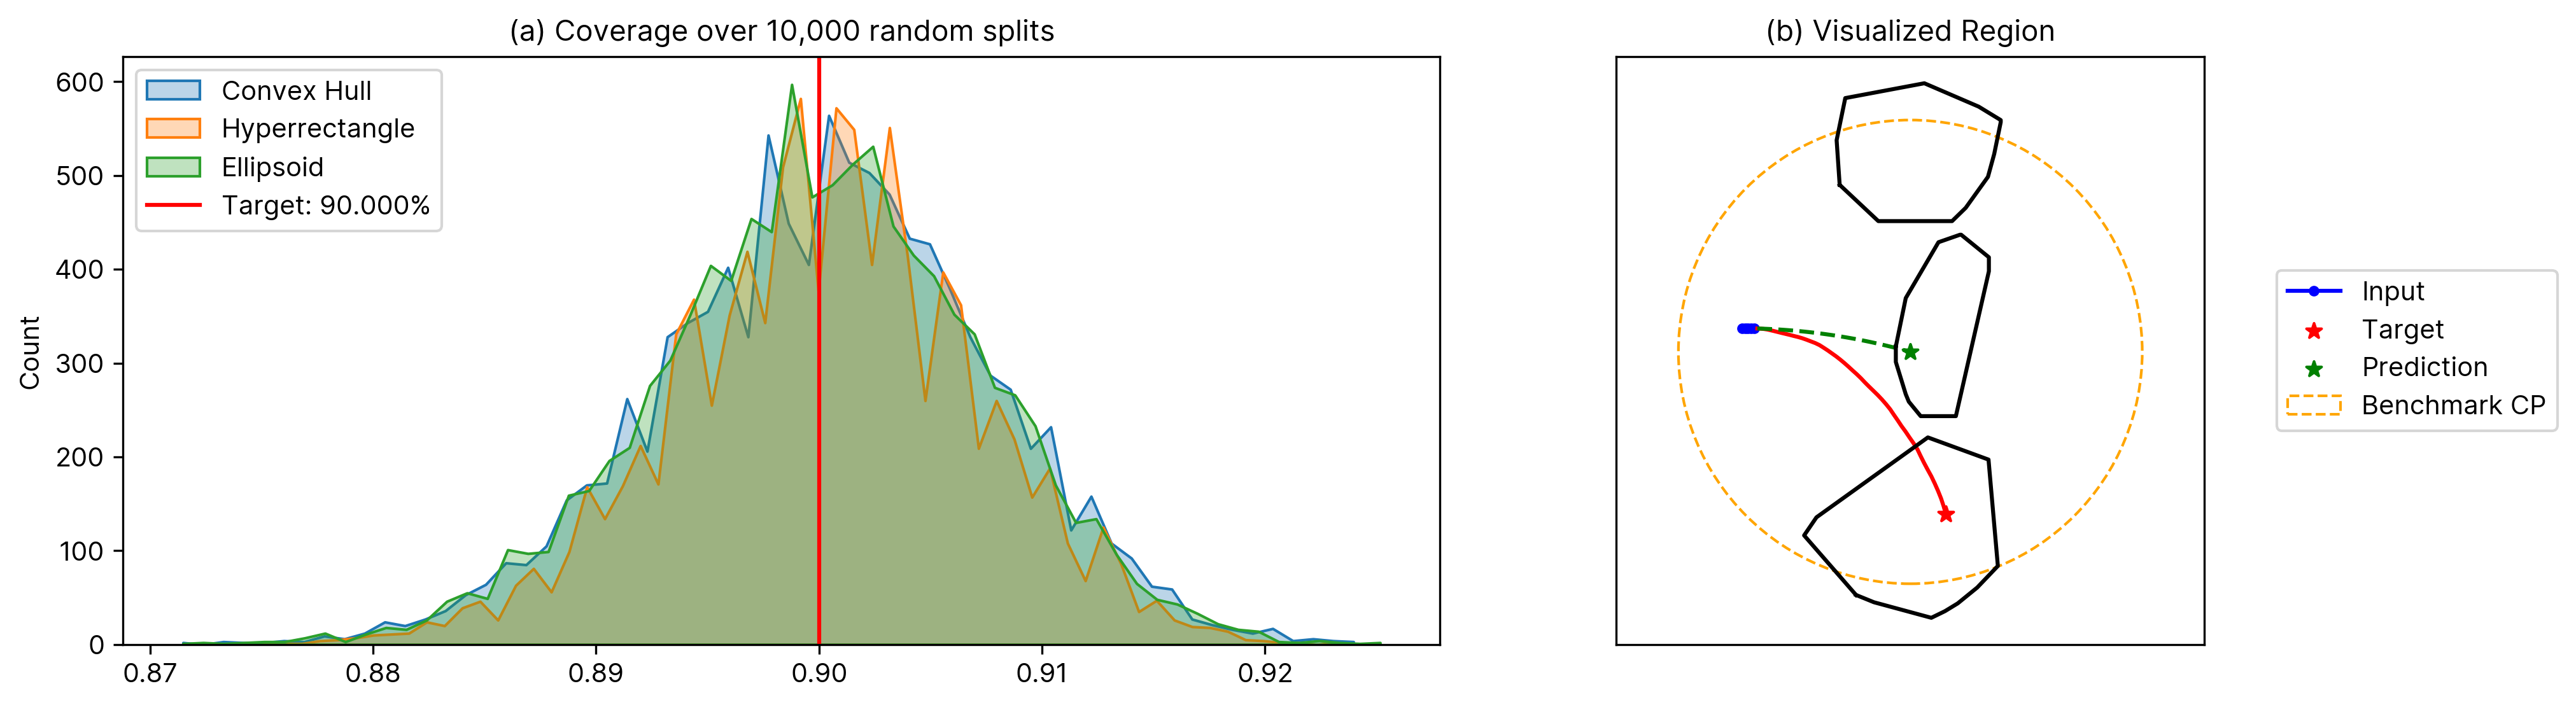

In [27]:
fig = plt.figure(figsize=(15, 4))
from matplotlib import gridspec
gs = gridspec.GridSpec(1,10)
ax1 = plt.subplot(gs[0, :6])
ax2 = plt.subplot(gs[0, 6:])

sns.histplot(cvxcoverages, element="poly", label="Convex Hull", alpha=0.3, ax=ax1)
sns.histplot(hrcoverages, element="poly", label="Hyperrectangle", alpha=0.3, ax=ax1)
sns.histplot(ellcoverages, element="poly", label="Ellipsoid", alpha=0.3, ax=ax1)
ax1.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
ax1.legend(loc='upper left')
ax1.set_title("(a) Coverage over 10,000 random splits")

i=1
prediction = predictor.predict_trajectory(env_X[INDEX[i]])
ax2.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
ax2.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
ax2.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
ax2.plot(prediction[:, 0], prediction[:, 1], 'g--')
ax2.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
for shape_template in cvxpcr.shapes:
    shape_template.plot(ax2, offset_coords=prediction[-1])
ax2.set_title(f'(b) Visualized Region')
# Plot benchmark CP region
bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle='--', fill=False, label='Benchmark CP')
ax2.add_patch(bcp_cir)
set_square_aspect_ratio(ax2)
ax2.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), borderaxespad=0.)
ax2.set_xticks([])
ax2.set_yticks([])
# Zoom out of ax2
# RANGE = 3
# CENTER = [0,-1]
# ax2.set_xlim(CENTER[0]-RANGE, CENTER[0]+RANGE)
# ax2.set_ylim(CENTER[1]-RANGE, CENTER[1]+RANGE)

In [28]:
figure_data = {
    'cvxcoverages': cvxcoverages,
    'hrcoverages': hrcoverages,
    'ellcoverages': ellcoverages,
    'prediction': prediction,
    'input': env_X[INDEX[i], :, :2],
    'output': env_Y[INDEX[i], :, :2],
    'benchmark_bound': bcp_conformal_bound,
    'cvxpcr': cvxpcr,
    'hrpcr': hrpcr,
    'ellpcr': ellpcr,
    'DELTA': DELTA
}
import pickle
pickle.dump(figure_data, open("car_experiments.pkl", "wb"))

In [29]:
from time import time
start = time()
cov = (cvxpcr.calculate_scores(Z_test)<0).mean()
end = time()
print(f'Coverage: {cov:.3f} | Time: {end-start:.8f}s')

Coverage: 0.905 | Time: 0.00301385s


In [30]:
from time import time
start = time()
cov = (hrpcr.calculate_scores(Z_test)<0).mean()
end = time()
print(f'Coverage: {cov:.3f} | Time: {end-start:.8f}s')

Coverage: 0.935 | Time: 0.00267720s


In [31]:
from time import time
start = time()
cov = (ellpcr.calculate_scores(Z_test)<0).mean()
end = time()
print(f'Coverage: {cov:.3f} | Time: {end-start:.8f}s')

Coverage: 0.909 | Time: 0.00312495s


In [32]:
Z_test.shape

(3334, 2)

In [33]:
cvxpcr.print_times()

DE time             : 0.8312904834747314
CL time             : 1.4368126392364502
ST time             : 0.0022666454315185547
Score time          : 0.0018889904022216797
Conformalize time   : 0.0013134479522705078
Total time          : 2.2735722064971924


In [34]:
hrpcr.print_times()

DE time             : 0.8326687812805176
CL time             : 0.5541296005249023
ST time             : 0.0002129077911376953
Score time          : 0.0012936592102050781
Conformalize time   : 0.0009949207305908203
Total time          : 1.3892998695373535


In [35]:
ellpcr.print_times()

DE time             : 0.8328540325164795
CL time             : 0.5762131214141846
ST time             : 3.760230302810669
Score time          : 0.0011696815490722656
Conformalize time   : 0.0009829998016357422
Total time          : 5.171450138092041


In [37]:
np.mean([1.4368126392364502,0.5541296005249023,0.5762131214141846])

0.8557184537251791